In [1]:
%%capture
!pip install super-gradients==3.2.0
!pip install imutils
!pip install roboflow
!pip install pytube --upgrade

In [2]:
from super_gradients.training import models

yolo_nas_l = models.get("yolo_nas_l", pretrained_weights="coco")

The console stream is logged into /root/sg_logs/console.log


[2024-05-11 01:35:13] INFO - crash_tips_setup.py - Crash tips is enabled. You can set your environment variable to CRASH_HANDLER=FALSE to disable it
[2024-05-11 01:35:22] WARNING - __init__.py - Failed to import pytorch_quantization
[2024-05-11 01:35:27] INFO - utils.py - NumExpr defaulting to 2 threads.
/usr/local/lib/python3.10/dist-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")
[2024-05-11 01:35:29] WARNING - calibrator.py - Failed to import pytorch_quantization
[2024-05-11 01:35:29] WARNING - export.py - Failed to import pytorch_quantization
[2024-05-11 01:35:29] WARNING - selective_quantization_utils.py - Failed to import pytorch_quantization
[2024-05-11 01:35:29] WARNING - env_sanity_check.py - Failed to verify installed packages: boto3 required but not found
[2024-05-11 01:35:29] WARNING - env_sanity_check.py - Failed to verify installed packages: deprecated required but not found
[20

In [3]:
!pip install torchinfo
from torchinfo import summary

summary(model=yolo_nas_l,
        input_size=(16, 3, 640, 640),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                                           Input Shape          Output Shape         Param #              Trainable
YoloNAS_L (YoloNAS_L)                                             [16, 3, 640, 640]    [16, 8400, 4]        --                   True
├─NStageBackbone (backbone)                                       [16, 3, 640, 640]    [16, 96, 160, 160]   --                   True
│    └─YoloNASStem (stem)                                         [16, 3, 640, 640]    [16, 48, 320, 320]   --                   True
│    │    └─QARepVGGBlock (conv)                                  [16, 3, 640, 640]    [16, 48, 320, 320]   3,024                True
│    └─YoloNASStage (stage1)                                      [16, 48, 320, 320]   [16, 96, 160, 160]   --                   True
│    │    └─QARepVGGBlock (downsample)                            [16, 48, 320, 320]   [16, 96, 160, 160]   88,128               True
│    │    └─YoloNASCSPLayer (blocks)                     

In [5]:
from super_gradients.training import Trainer

CHECKPOINT_DIR = 'checkpoints'
trainer = Trainer(experiment_name='my_first_yolonas_run', ckpt_root_dir=CHECKPOINT_DIR)

In [6]:
from roboflow import Roboflow
rf = Roboflow(api_key="Bfs4O3BiokiFCiKBQwpI")
project = rf.workspace("bearingfault").project("bearing-defect-1")
dataset = project.version(5).download("yolov9")

loading Roboflow workspace...
loading Roboflow project...
Exporting format yolov9 in progress : 85.0%
Version export complete for yolov9 format


Extracting Dataset Version Zip to Bearing-Defect-1-5 in yolov9::  17%|█▋        | 509/3018 [00:00<00:00, 5088.69it/s]

Extracting Dataset Version Zip to Bearing-Defect-1-5 in yolov9:: 100%|██████████| 3018/3018 [00:00<00:00, 5412.39it/s]


Start by importing the required modules, which will help you create SuperGradients dataloaders.


In [7]:
from super_gradients.training import dataloaders
from super_gradients.training.dataloaders.dataloaders import coco_detection_yolo_format_train, coco_detection_yolo_format_val

You'll need to load your dataset parameters into a dictionary, specifically defining:

- path to the parent directory where your data lives
- the child directory names for training, validation, and test (if you have testing set) images and labels
- class names

In [10]:
dataset_params = {
    'data_dir':'/content/Bearing-Defect-1-5',
    'train_images_dir':'train/images',
    'train_labels_dir':'train/labels',
    'val_images_dir':'valid/images',
    'val_labels_dir':'valid/labels',
    'test_images_dir':'test/images',
    'test_labels_dir':'test/labels',
    'classes': ['0']
}

In [11]:
from IPython.display import clear_output

train_data = coco_detection_yolo_format_train(
    dataset_params={
        'data_dir': dataset_params['data_dir'],
        'images_dir': dataset_params['train_images_dir'],
        'labels_dir': dataset_params['train_labels_dir'],
        'classes': dataset_params['classes']
    },
    dataloader_params={
        'batch_size':16,
        'num_workers':2
    }
)

val_data = coco_detection_yolo_format_val(
    dataset_params={
        'data_dir': dataset_params['data_dir'],
        'images_dir': dataset_params['val_images_dir'],
        'labels_dir': dataset_params['val_labels_dir'],
        'classes': dataset_params['classes']
    },
    dataloader_params={
        'batch_size':16,
        'num_workers':2
    }
)

test_data = coco_detection_yolo_format_val(
    dataset_params={
        'data_dir': dataset_params['data_dir'],
        'images_dir': dataset_params['test_images_dir'],
        'labels_dir': dataset_params['test_labels_dir'],
        'classes': dataset_params['classes']
    },
    dataloader_params={
        'batch_size':16,
        'num_workers':2
    }
)

clear_output()

Indexing dataset annotations: 100%|██████████| 81/81 [00:00<00:00, 5950.62it/s]


### this is transofrm with augmentation. Dont need it.

In [12]:
train_data.dataset.transforms

[DetectionMosaic('additional_samples_count': 3, 'non_empty_targets': False, 'prob': 1.0, 'input_dim': (640, 640), 'enable_mosaic': True, 'border_value': 114),
 DetectionRandomAffine('additional_samples_count': 0, 'non_empty_targets': False, 'degrees': 10.0, 'translate': 0.1, 'scale': [0.1, 2], 'shear': 2.0, 'target_size': (640, 640), 'enable': True, 'filter_box_candidates': True, 'wh_thr': 2, 'ar_thr': 20, 'area_thr': 0.1, 'border_value': 114),
 DetectionMixup('additional_samples_count': 1, 'non_empty_targets': True, 'input_dim': (640, 640), 'mixup_scale': [0.5, 1.5], 'prob': 1.0, 'enable_mixup': True, 'flip_prob': 0.5, 'border_value': 114),
 DetectionHSV('additional_samples_count': 0, 'non_empty_targets': False, 'prob': 1.0, 'hgain': 5, 'sgain': 30, 'vgain': 30, 'bgr_channels': (0, 1, 2), '_additional_channels_warned': False),
 DetectionHorizontalFlip('additional_samples_count': 0, 'non_empty_targets': False, 'prob': 0.5),
 DetectionPaddedRescale('additional_samples_count': 0, 'non_em

You can plot a batch of training data with their augmentations applied to see what they look like:

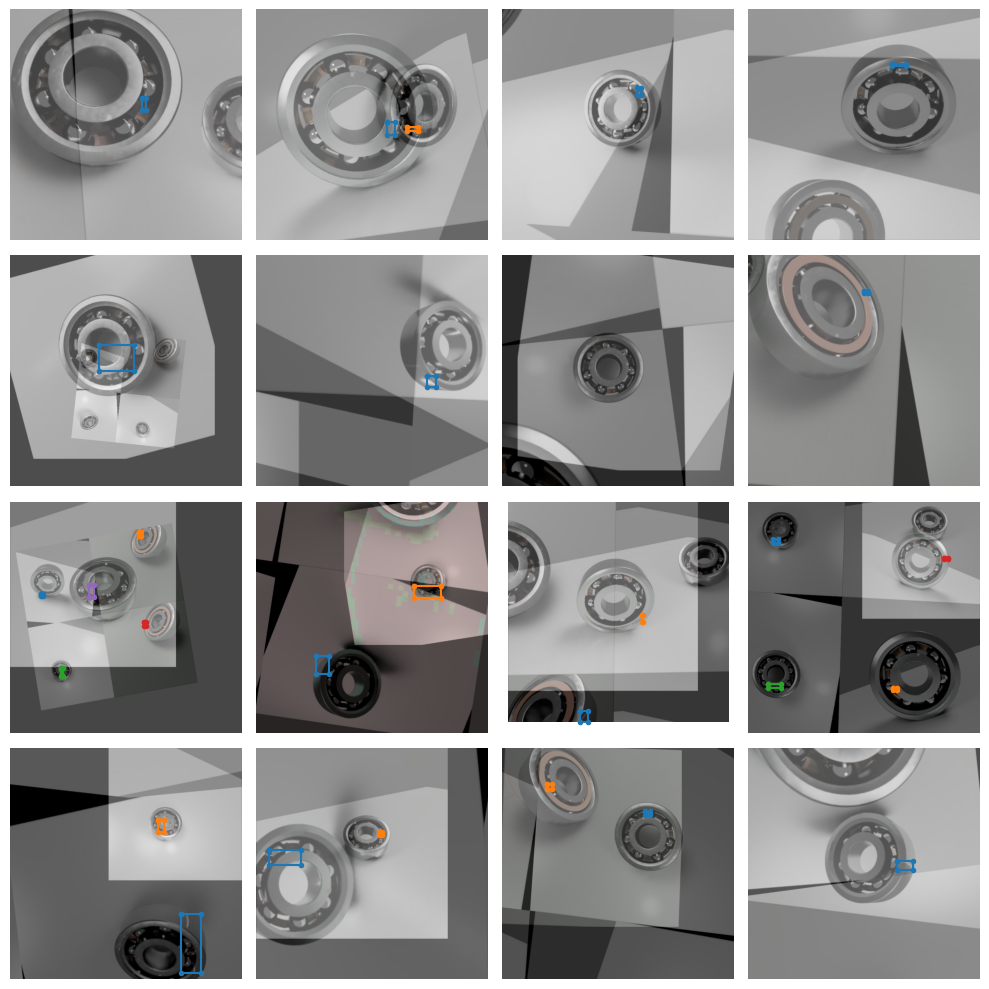

In [13]:
train_data.dataset.plot()

In [14]:
from super_gradients.training import models
model = models.get('yolo_nas_l',
                   num_classes=len(dataset_params['classes']),
                   pretrained_weights="coco"
                   )

[2024-05-11 01:49:58] INFO - checkpoint_utils.py - License Notification: YOLO-NAS pre-trained weights are subjected to the specific license terms and conditions detailed in 
https://github.com/Deci-AI/super-gradients/blob/master/LICENSE.YOLONAS.md
By downloading the pre-trained weight files you agree to comply with these terms.
[2024-05-11 01:49:58] INFO - checkpoint_utils.py - Successfully loaded pretrained weights for architecture yolo_nas_l


In [15]:
from super_gradients.training.losses import PPYoloELoss
from super_gradients.training.metrics import DetectionMetrics_050
from super_gradients.training.models.detection_models.pp_yolo_e import PPYoloEPostPredictionCallback

train_params = {
    # ENABLING SILENT MODE
    'silent_mode': True,
    "average_best_models":True,
    "warmup_mode": "linear_epoch_step",
    "warmup_initial_lr": 1e-6,
    "lr_warmup_epochs": 3,
    "initial_lr": 5e-4,
    "lr_mode": "cosine",
    "cosine_final_lr_ratio": 0.1,
    "optimizer": "Adam",
    "optimizer_params": {"weight_decay": 0.0001},
    "zero_weight_decay_on_bias_and_bn": True,
    "ema": True,
    "ema_params": {"decay": 0.9, "decay_type": "threshold"},
    # ONLY TRAINING FOR 10 EPOCHS FOR THIS EXAMPLE NOTEBOOK
    "max_epochs": 10,
    "mixed_precision": True,
    "loss": PPYoloELoss(
        use_static_assigner=False,
        # NOTE: num_classes needs to be defined here
        num_classes=len(dataset_params['classes']),
        reg_max=16
    ),
    "valid_metrics_list": [
        DetectionMetrics_050(
            score_thres=0.1,
            top_k_predictions=300,
            # NOTE: num_classes needs to be defined here
            num_cls=len(dataset_params['classes']),
            normalize_targets=True,
            post_prediction_callback=PPYoloEPostPredictionCallback(
                score_threshold=0.01,
                nms_top_k=1000,
                max_predictions=300,
                nms_threshold=0.7
            )
        )
    ],
    "metric_to_watch": 'mAP@0.50'
}

In [16]:
trainer.train(model=model,
              training_params=train_params,
              train_loader=train_data,
              valid_loader=val_data)

The console stream is now moved to checkpoints/my_first_yolonas_run/console_May11_01_50_10.txt


[2024-05-11 01:50:11] INFO - sg_trainer.py - Using EMA with params {'decay': 0.9, 'decay_type': 'threshold'}
os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
[2024-05-11 01:50:18] INFO - sg_trainer_utils.py - TRAINING PARAMETERS:
    - Mode:                         Single GPU
    - Number of GPUs:               1          (1 available on the machine)
    - Dataset size:                 1163       (len(train_set))
    - Batch size per GPU:           16         (batch_size)
    - Batch Accumulate:             1          (batch_accumulate)
    - Total batch size:             16         (num_gpus * batch_size)
    - Effective Batch size:         16         (num_gpus * batch_size * batch_accumulate)
    - Iterations per epoch:         72         (len(train_loader))
    - Gradient updates per epoch:   72         (len(train_loader) / batch_accumulate)

[2024-05-11 01:52:31] INFO - base_sg_logger.py - Che

# 🏆 Get the best trained model

Now that training is complete, you need to get the best trained model.

You used checkpoint averaging so the following code will use weights averaged across training runs.

If you want to use the best weights, or weights from the last epoch you'd use one of the following in the code below:

- best weights: `checkpoint_path = checkpoints/my_first_yolonas_run/ckpt_best.pth`

- last weights: `checkpoint_path = checkpoints/my_first_yolonas_run/ckpt_latest.pth`

In [23]:
best_model = models.get('yolo_nas_l',
                        num_classes=len(dataset_params['classes']),
                        checkpoint_path="checkpoints/my_first_yolonas_run/ckpt_best.pth")

# best trained model on the test set

In [24]:
trainer.test(model=best_model,
            test_loader=test_data,
            test_metrics_list=DetectionMetrics_050(score_thres=0.1,
                                                   top_k_predictions=300,
                                                   num_cls=len(dataset_params['classes']),
                                                   normalize_targets=True,
                                                   post_prediction_callback=PPYoloEPostPredictionCallback(score_threshold=0.01,
                                                                                                          nms_top_k=1000,
                                                                                                          max_predictions=300,
                                                                                                          nms_threshold=0.2)
                                                  ))

Testing:  80%|████████  | 4/5 [00:04<00:00,  1.03it/s]

{'PPYoloELoss/loss_cls': 1.1865797,
 'PPYoloELoss/loss_iou': 0.40335834,
 'PPYoloELoss/loss_dfl': 1.2669045,
 'PPYoloELoss/loss': 2.8284273,
 'Precision@0.50': 0.06382978707551956,
 'Recall@0.50': 0.20270270109176636,
 'mAP@0.50': 0.07871513813734055,
 'F1@0.50': 0.09708738327026367}

Testing: 100%|██████████| 5/5 [00:05<00:00,  1.08s/it]


[2024-05-11 02:24:25] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`


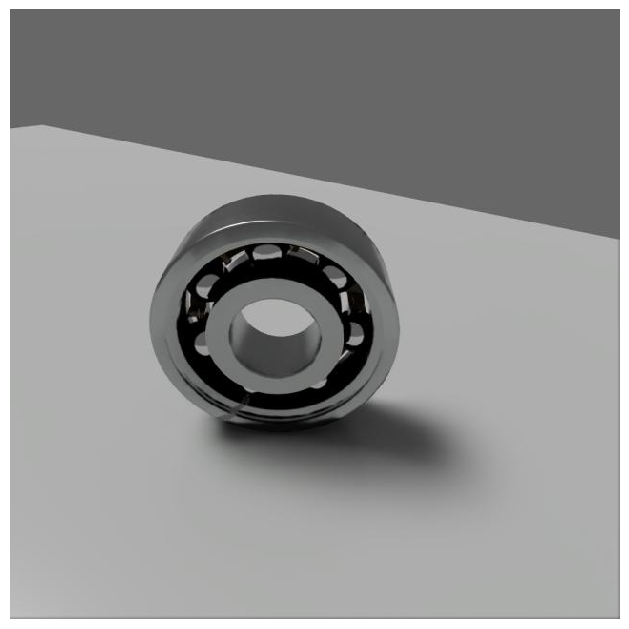

In [26]:
img_url = '/content/Bearing-Defect-1-5/test/images/rgb_0000_png.rf.1198f9723594a309cd69cd1fb2a018ef.jpg'
best_model.predict(img_url).show()